# BCDP CORDEX Example
## Quick Overview
Here we will do a quick walkthrough of using BCDP to process some regional climate simulations from the Coordinate Regional Downscaling Experiment

In [1]:
import os
import glob
import numpy as np
import bcdp

Create a file conventions template. Here we only need the model and variable names so the rest of the file template is filled in by wildcards.

In [2]:
project = 'CORDEX-Africa'
template = '*_{model}_*_{variable}.nc'
bcdp.build_extractor(project, template, name_field='model', index=[1, 6])

bcdp.extractors.build_extractor_from_params.<locals>.GenericExtractor

Load the data. Because we have loaded the template, the loader now knows exactly how to extract the required informations from the filenames.

In [3]:
paths = os.path.join(os.path.expanduser('~'), 'data/CORDEX_Africa/*clt*')
ens = bcdp.load_local(paths=paths, project=project)
print(ens.size)

297.91MB


In [4]:
ens.data.values

array([<xarray.DataArray 'CNRM-ARPEGE51' (time: 240, y: 201, x: 194)>
       array([[[0.761036, 0.761144, ..., 0.801506, 0.805053],
               [0.780496, 0.781563, ..., 0.796294, 0.797647],
               ...,
               [0.704399, 0.696516, ..., 0.480617, 0.498538],
               [0.724584, 0.715992, ..., 0.482805, 0.497622]],

              [[0.836083, 0.836951, ..., 0.607263, 0.623823],
               [0.808962, 0.812403, ..., 0.608459, 0.626429],
               ...,
               [0.734305, 0.709068, ..., 0.307973, 0.317278],
               [0.766879, 0.743069, ..., 0.351661, 0.356004]],

              ...,

              [[0.726492, 0.724162, ..., 0.822254, 0.821955],
               [0.707536, 0.706722, ..., 0.803323, 0.79847 ],
               ...,
               [0.760895, 0.753873, ..., 0.128632, 0.131804],
               [0.765997, 0.759125, ..., 0.112504, 0.113516]],

              [[0.704635, 0.713988, ..., 0.746423, 0.747219],
               [0.722519, 0.732533, ..

The loader returns an `Ensemble` object, which is essentially a collection of datasets and applies preprocessing operations to each of them. Here we will regrid the data to a coarser (0.88 degree) grid using bilinear interpolation, and consider only the winter months (DJF).

In [5]:
output_grid = bcdp.utils.grid_from_res((0.88, 0.88), ens.overlap)
ens_u = ens.homogenize(backend='scipy', method='linear',
                       output_grid=output_grid, clean=False)

Now that the underlying datastructures are homogeneous (same grid and time step), we can convert it to an xarray dataarray which has dimensions (names, time, lat, lon).

In [6]:
def show_ens(ens):
    da = ens.bundle('CORDEX').add_mean('CORDEX').first
    da.to_netcdf('CORDEX_Africa_clt.nc')
    da.mean('time').plot(x='x', y='y', col='names', col_wrap=3)

We can easily visualize the annual climatology with xarray's built-in plotting methods.

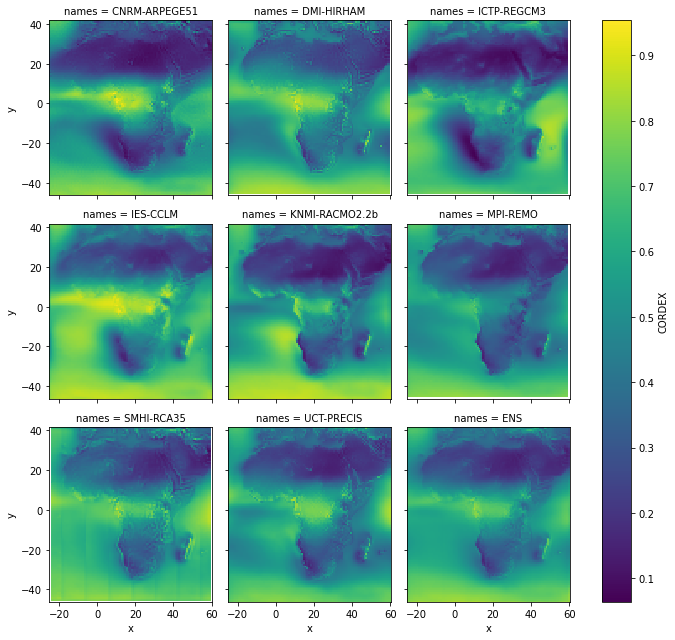

In [7]:
show_ens(ens_u)

## What's actually happening
`homogenize()` is actually a shortcut to perform multiple processing operations on the datasets at once. These include:
- Normalizing datetimes via `normalize_times()` (including accounting for different calendars) (`normalize_datetimes`) 
- Spatial and Temporal Subsetting via `subset()` (Including BBox and to shapefile/geojson polygons)
- Subdivide each year of data by specified season via `select_season()`
- Resampling via `resample()` (Set all datasets to same temporal frequency)
- Regridding via `regrid()` (Set all datasets to same spatial resolution)

### Susbetting
Subsetting requires a call to the `subset()` method on Ensemble objects.

In [8]:
ens.subset()

#### Spatial Subsetting

By default, the domain used for subsetting is actually the spatial-temporal overlap of all the included datasets. This is a special accessor for the Ensemble called `overlap`

In [9]:
print(ens.overlap)
print(ens.overlap.lat_bnds)
print(ens.overlap.lon_bnds)
print(ens.overlap.time_bnds)

(-45.76, 42.24)
(-24.64, 60.28)
(numpy.datetime64('1990-01-15T00:00:00.000000000'), numpy.datetime64('2008-11-16T00:00:00.000000000'))


We can subset to a different bounding box domain by creating our own `Bounds` object and using it as our input to `subset()`

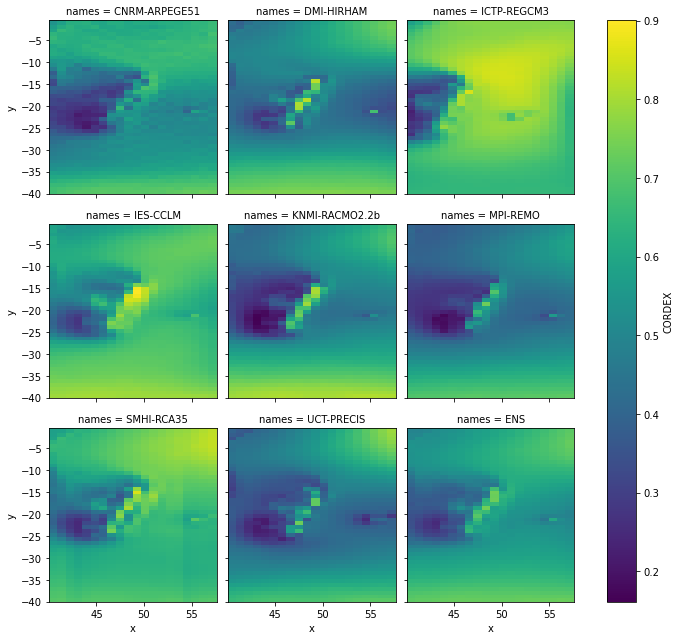

In [10]:
bbox = bcdp.Bounds(lat_bnds=(-40, 0), lon_bnds=(40, 58), time_bnds=ens.overlap.time_bnds)
ens_sub = ens_u.subset(bbox)
show_ens(ens_sub)

We can also load boundary data (eg, GeoJSON or Shapefiles) for more sophisticated subsetting.

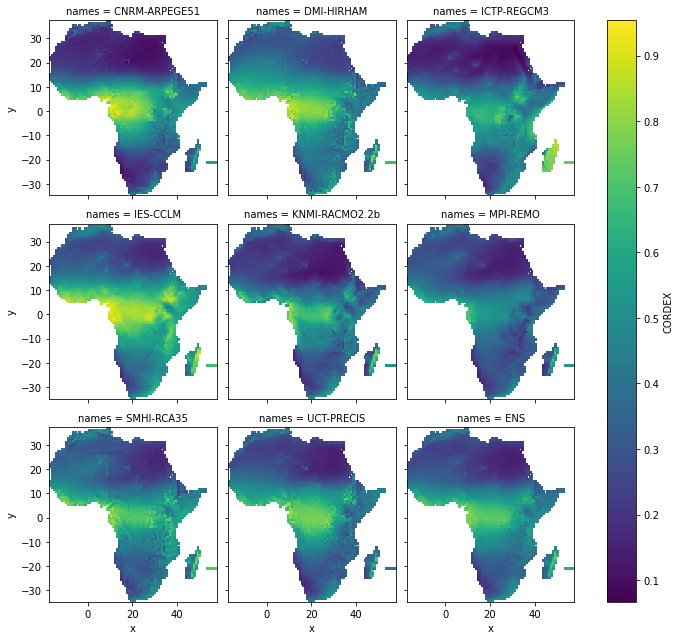

In [11]:
boundary = bcdp.PolygonBounds('/Users/goodman/data/boundaries/africa.json', field='name', time_bnds=ens.overlap.time_bnds)
ens_sub = ens_u.subset(boundary)
show_ens(ens_sub)

We can even narrow down specific regions defined in the boundary file if we so wish

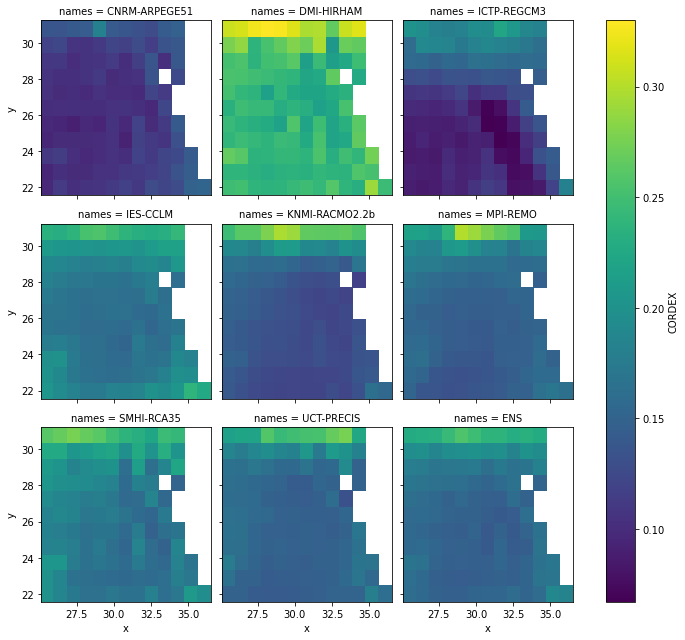

In [12]:
boundary = bcdp.PolygonBounds('/Users/goodman/data/boundaries/africa.json', field='name', time_bnds=ens.overlap.time_bnds, names=['Egypt'])
ens_sub = ens_u.subset(boundary)
show_ens(ens_sub)

#### Selecting Seasons
Standard spatial subsetting and time slicing are done via `subset()`, but we can subset by specific season using `select_season()`

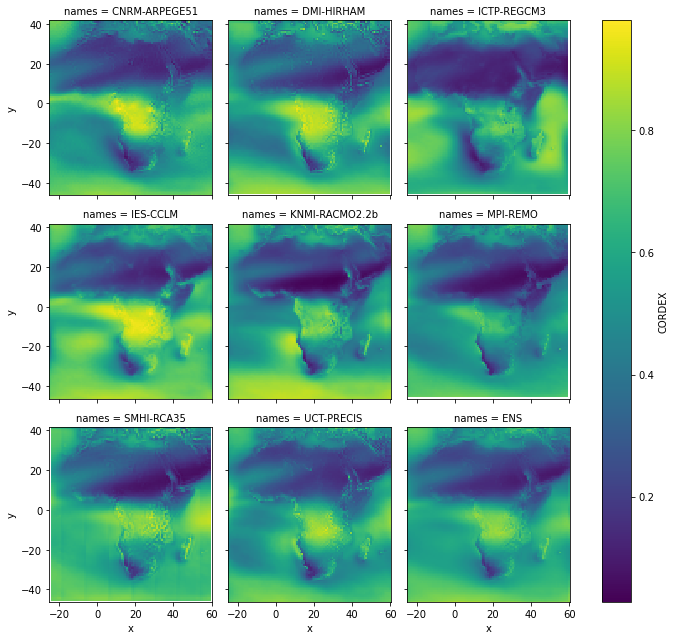

In [13]:
ens_sub = ens_u.select_season('DJF')
show_ens(ens_sub)